# Stocks Converter

This project demonstrates the usage of TensorCircuit Stock Converter.

## Define the converter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class StockData:
    """
    A class for converting real-world stock data to an annualized covariance matrix and annualized return.

    Attributes:
    - data: A list of continuous stock data in the same time span.
    - n_stocks: The number of stocks in the data.
    - n_days: The number of trading days in the data.

    Methods:
    - __init__(self, data): Initializes the StockData object.
    - get_return(self, decimals=5): Calculates the annualized return.
    - get_covariance(self, decimals=5): Calculates the annualized covariance matrix.
    - get_penalty(self, cov, ret, risk_pre, budget, decimals=5): Calculates the penalty factor.
    """

    def __init__(self, data):
        """
        Initializes the StockData object.

        :param data: A list of continuous stock data in the same time span.
        """
        self.data = data
        self.n_stocks = len(data)

        # Check the number of days
        n_days = [len(i) for i in data]
        if max(n_days) != (sum(n_days) / len(n_days)):
            raise Exception("Timespan of stocks should be the same")
        self.n_days = len(data[1])

        # Calculate the daily percentage price change
        self.daily_change = []
        for i in range(self.n_stocks):
            each_stock = []
            for j in range(self.n_days - 1):
                each_stock.append((data[i][j + 1] - data[i][j]) / data[i][j + 1])
            self.daily_change.append(each_stock)

    def get_return(self, decimals=5):
        """
        Calculates the annualized return (mu).

        :param decimals: Number of decimal places to round the result to (default: 5).
        :return: The annualized return as an array rounded to the specified number of decimals.
        """
        change = [[j + 1 for j in i] for i in self.daily_change]
        ret = np.prod(change, axis=1) ** (252 / self.n_days)
        return ret.round(decimals)

    def get_covariance(self, decimals=5):
        """
        Calculates the annualized covariance matrix (sigma).

        :param decimals: Number of decimal places to round the result to (default: 5).
        :return: The annualized covariance matrix rounded to the specified number of decimals.
        """
        mean = np.mean(self.daily_change, axis=1)
        relative_change = [
            [j - mean[i] for j in self.daily_change[i]] for i in range(6)
        ]
        cov = 252 / self.n_days * np.dot(relative_change, np.transpose(relative_change))
        return cov.round(decimals)

    def get_penalty(self, cov, ret, risk_pre, budget, decimals=5):
        """
        Calculates the penalty factor.

        :param cov: The annualized covariance matrix.
        :param ret: The annualized return.
        :param risk_pre: The risk preference factor.
        :param budget: The budget (number of stocks to select).
        :param decimals: Number of decimal places to round the result to (default: 5).
        :return: The penalty factor rounded to the specified number of decimals.
        """
        # Get all feasible and unfeasible states
        self.f_state = []  # Feasible states (number of '1's equal to budget)
        self.uf_state = []  # Unfeasible states
        self.all_state = []
        for i in range(2**self.n_stocks):
            state = f"{bin(i)[2:]:0>{self.n_stocks}}"
            n_ones = 0
            for j in state:
                if j == "1":
                    n_ones += 1
            self.all_state.append(state)
            if n_ones == budget:
                self.f_state.append(state)
            else:
                self.uf_state.append(state)

        # Determine the penalty factor
        mark = False
        penalty = 0  # Initial value
        while mark == False:
            R = np.diag(ret)
            S = np.ones((self.n_stocks, self.n_stocks)) - 2 * budget * np.diag(
                np.ones(self.n_stocks)
            )
            Q = risk_pre * cov - R + penalty * S
            F = []
            for state in self.f_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty * budget**2)
            Fmin = np.amin(F)
            Fbar = np.mean(F)
            F = []
            for state in self.uf_state:
                x = np.array([int(bit) for bit in state])
                F.append(np.dot(x, np.dot(Q, x)) + penalty * budget**2)
            Fmin_uf = np.amin(F)
            location = np.where(F == Fmin_uf)[0][0]
            if Fmin_uf < 0.5 * (Fmin + Fbar):
                n_ones = 0
                for j in self.uf_state[location]:
                    if j == "1":
                        n_ones += 1
                penalty += (0.5 * (Fmin + Fbar) - Fmin_uf) / (n_ones - budget) ** 2
            else:
                mark = True  # Ready to return the penalty
        return round(penalty, decimals)

## Import data

[1.21141, 1.15325, 2.06457, 0.63539, 0.63827, 1.12224] 
 [[0.08488, 0.06738, 0.09963, 0.02124, 0.05516, 0.04059], [0.06738, 0.10196, 0.11912, 0.02163, 0.0498, 0.04049], [0.09963, 0.11912, 0.31026, 0.01977, 0.10415, 0.06179], [0.02124, 0.02163, 0.01977, 0.05175, 0.01792, 0.02137], [0.05516, 0.0498, 0.10415, 0.01792, 0.19366, 0.0432], [0.04059, 0.04049, 0.06179, 0.02137, 0.0432, 0.05052]] 
 1.33314


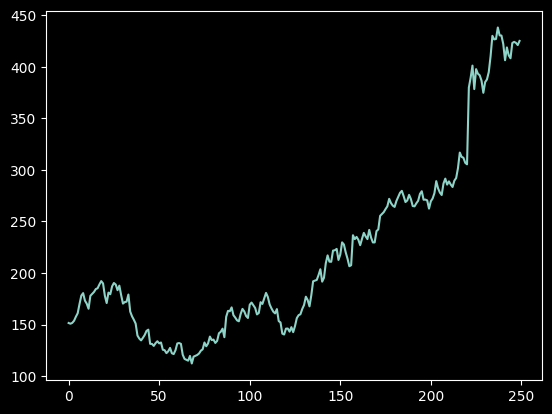

In [3]:
import pandas as pd
aapl = pd.read_csv('AAPL.csv')
msft = pd.read_csv('MSFT.csv')
nvda = pd.read_csv('NVDA.csv')
pfe = pd.read_csv('PFE.csv')
levi = pd.read_csv('LEVI.csv')
csco = pd.read_csv('CSCO.csv')
names = [aapl, msft, nvda, pfe, levi, csco]
data = []
for i in names:
    i['Close'].to_string
    data.append([j for j in i['Close'].transpose()])
plt.plot(data[2])
stock_data = StockData(data)
ret = stock_data.get_return()
cov = stock_data.get_covariance()
penalty = stock_data.get_penalty(cov, ret, 0.5, 3)
print(list(ret), '\n', np.array(cov).tolist(), '\n', penalty)

In [4]:
a = np.array([[1, 2], [3, 4]])
a

array([[1, 2],
       [3, 4]])

In [5]:

93905.89369161372**1.00398406374502

98288.87754532037

# Classical

In [6]:
states = []
for i in range(2**6):
    a = f"{bin(i)[2:]:0>{6}}"
    n_ones = 0
    for j in a:
        if j == '1':
            n_ones += 1
    if True:#n_ones != 3:
        states.append(a)

In [7]:
def QUBO_from_portfolio(cov, mean, q, B, t):
    """convert portfolio parameters to a Q-matrix
    cov: n-by-n covariance numpy array
    mean: numpy array of means
    q: the risk preference of investor
    B: budget
    t: penalty factor
    """
    n = cov.shape[0]
    R = np.diag(mean)
    S = np.ones((n, n)) - 2 * B * np.diag(np.ones(n))

    Q = q * cov - R + t * S
    return Q

In [8]:
Q = QUBO_from_portfolio(cov, ret, 0.5, 4, penalty)

In [9]:
# Brutely search over classical results for comparison before we run QAOA
# the results are sorted with cost
cost_dict = {}
i = 0
for selection in states:
    x = np.array([int(bit) for bit in selection])
    cost_dict[selection] = np.dot(x, np.dot(Q, x))
    i += 1
cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
print("\n-------------------------------------")
print("    selection\t  |\t  cost")
print("-------------------------------------")
for k, v in cost_sorted.items():
    print("%10s\t  |\t%.4f" % (k, v))
print("-------------------------------------")


-------------------------------------
    selection	  |	  cost
-------------------------------------
    111001	  |	-26.1789
    101101	  |	-25.8508
    111100	  |	-25.7717
    011101	  |	-25.7643
    101011	  |	-25.6425
    011011	  |	-25.5618
    111010	  |	-25.5571
    111101	  |	-25.3713
    101110	  |	-25.2417
    001111	  |	-25.2194
    011110	  |	-25.1605
    111011	  |	-25.1349
    110101	  |	-25.0953
    110011	  |	-24.9433
    101111	  |	-24.8386
    011111	  |	-24.7575
    111110	  |	-24.7529
    100111	  |	-24.5477
    110110	  |	-24.5193
    010111	  |	-24.4860
    110111	  |	-24.1375
    101001	  |	-23.9705
    111000	  |	-23.8916
    011001	  |	-23.8844
    101100	  |	-23.5444
    001101	  |	-23.5101
    011100	  |	-23.4578
    101010	  |	-23.3580
    001011	  |	-23.3358
    011010	  |	-23.2772
    110001	  |	-23.2169
    001110	  |	-22.9157
    100101	  |	-22.7894
    110100	  |	-22.7676
    010101	  |	-22.7224
    100011	  |	-22.6655
    110010	  |	-22.6374
    010011